In [7]:
import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import copy
from keras.utils.vis_utils import plot_model

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input_sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('(var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def data_preprocessing(step_size):
    '''
    loda data and transform data into train set and test set
    features: O, H, L, C
    '''
    df_final = pd.read_csv('result_AAPL_new.csv')
    df_final.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Pct_change_raw', 'Compound_multiplied_raw']
    # avoid the data leakage problem
    df_final['Pct_change'] = df_final['Pct_change_raw'].shift(1)
    df_final.drop(['Pct_change_raw'], axis=1, inplace=True)
    df_final['Compound_multiplied'] = df_final['Compound_multiplied_raw'].shift(1)
    df_final.drop(['Compound_multiplied_raw'], axis=1, inplace=True)
    df_final.dropna(axis=0, how='any', inplace=True)
    dataset = df_final
    dataset['Date'] = pd.to_datetime(dataset.Date, format='%Y-%m-%d')
    dataset.index = dataset['Date']
    dataset = dataset.sort_index(ascending=True, axis=0)
    dataset.drop(['Date'], axis=1, inplace=True)

    values = dataset.values # 67 * 6
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, step_size, 1) # 5
    print(reframed.shape)
    # split into train and test sets
    values = reframed.values

    n_train_days = 61 - 1
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    return train, test, scaler

In [12]:
from keras.layers import LSTM, Dropout, Dense, LeakyReLU

step_size = 5
feature_num = 6

generator_input = keras.Input(shape=(step_size, feature_num))
x = LSTM(75, return_sequences=True)(generator_input)
x = Dropout(0.2)(x)
x = LSTM(25)(x)
x = Dense(1)(x)
x = LeakyReLU()(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = keras.Input(shape=(step_size+1, 1))
y = Dense(72)(discriminator_input)
y = LeakyReLU(alpha=0.05)(y)
y = Dense(100)(y)
y = LeakyReLU(alpha=0.05)(y)
y = Dense(10)(y)
y = LeakyReLU(alpha=0.05)(y)
y = Dense(1, activation='sigmoid')(y)
discriminator = keras.models.Model(discriminator_input, y)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 75)             24600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 75)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1)                 0         
Total params: 34,726
Trainable params: 34,726
Non-trainable params: 0
_________________________________________________________

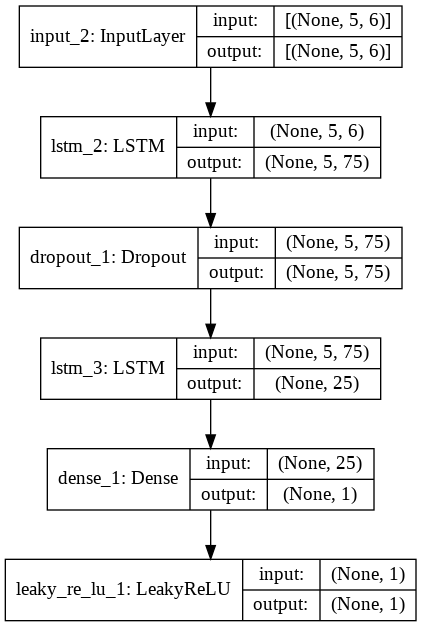

In [17]:
plot_model(generator, to_file='model_G.png', show_shapes=True, show_layer_names=True)


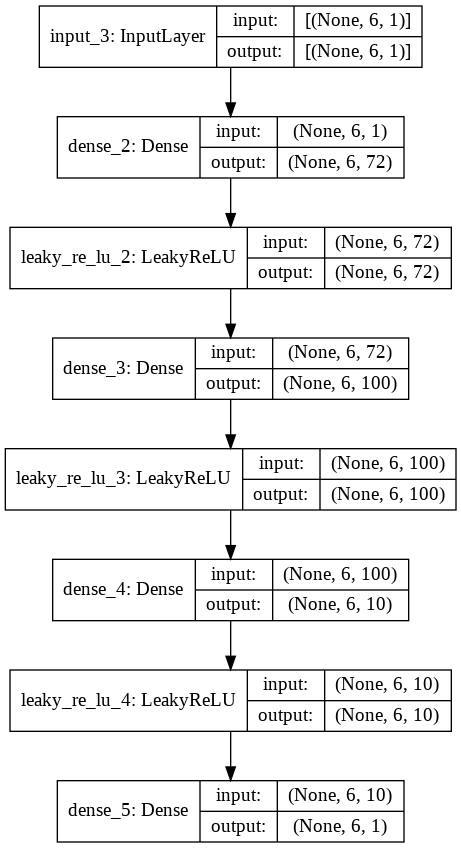

In [16]:
plot_model(discriminator, to_file='model_D.png', show_shapes=True, show_layer_names=True)

In [18]:
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=8e-4, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# optimizer 정의
discriminator.trainalb = False
gan_input = keras.Input(shape=(step_size, feature_num))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(learning_rate=4e-4, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# preparation of time series dataset
train, test, scaler = data_preprocessing(step_size)
# split into input and outputs
n_obs = step_size * feature_num
train_X, train_Y = train[:, :n_obs], train[:, -feature_num] # open price
test_X, test_Y = test[:, :n_obs], test[:, -feature_num] 
print(train_X.shape, len(train_X), train_Y.shape)
# reshape input to be 3D [samples, timesteps, features]
trainX = train_X.reshape((train_X.shape[0], step_size, feature_num))
testX = test_X.reshape((test_X.shape[0], step_size, feature_num))

# 파라미터 정의
iterations = 61 - 1
batch_size = 1
start = 0
final = []


FileNotFoundError: ignored

In [ ]:

#이터레이션 시작 
for step in range(iterations):
	print(step)
	temp_X = copy.deepcopy(trainX[step])
	temp_X = temp_X.reshape(batch_size,step_size,feature_num)
	temp_Y = copy.deepcopy(train_Y[step])
	temp_Y = temp_Y.reshape(batch_size,1)
	predictions = generator.predict(temp_X)
	# discrriminator 
	for i in range(25):
		aaa = trainX[step]
		input_f = np.concatenate([np.transpose(np.array([aaa[:,0]])), predictions], 0)
		input_r = np.concatenate([np.transpose(np.array([aaa[:,0]])), temp_Y], 0)
		input = np.concatenate([[input_f],[input_r]])
		labels = np.concatenate([[np.ones((6, 1))], [np.zeros((6, 1))]])
		d_loss = discriminator.train_on_batch(input, labels)
	# generator 
	for i in range(5):
		misleading_targets = np.zeros((batch_size, 1))
		a_loss = gan.train_on_batch(temp_X, [misleading_targets])
	final.append(predictions[0])
final = np.concatenate((np.array(final), train_X[:, -5:]), axis=1)
final2 = np.concatenate((np.transpose(np.array([train_Y])), train_X[:, -5:]), axis=1)
int1 = scaler.inverse_transform(final)
int2 = scaler.inverse_transform(final2)
MAPE_O1 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('training result:',MAPE_O1)


In [ ]:

final = []
for step in range(5):
	temp_X = copy.deepcopy(testX[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])

final = np.concatenate((np.array(final), test_X[:, -5:]), axis=1)
final2 = np.concatenate((np.transpose(np.array([test_Y])), test_X[:, -5:]), axis=1)
int1 = scaler.inverse_transform(final)
int2 = scaler.inverse_transform(final2)
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('testing result:',MAPE_O2)